# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2044 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

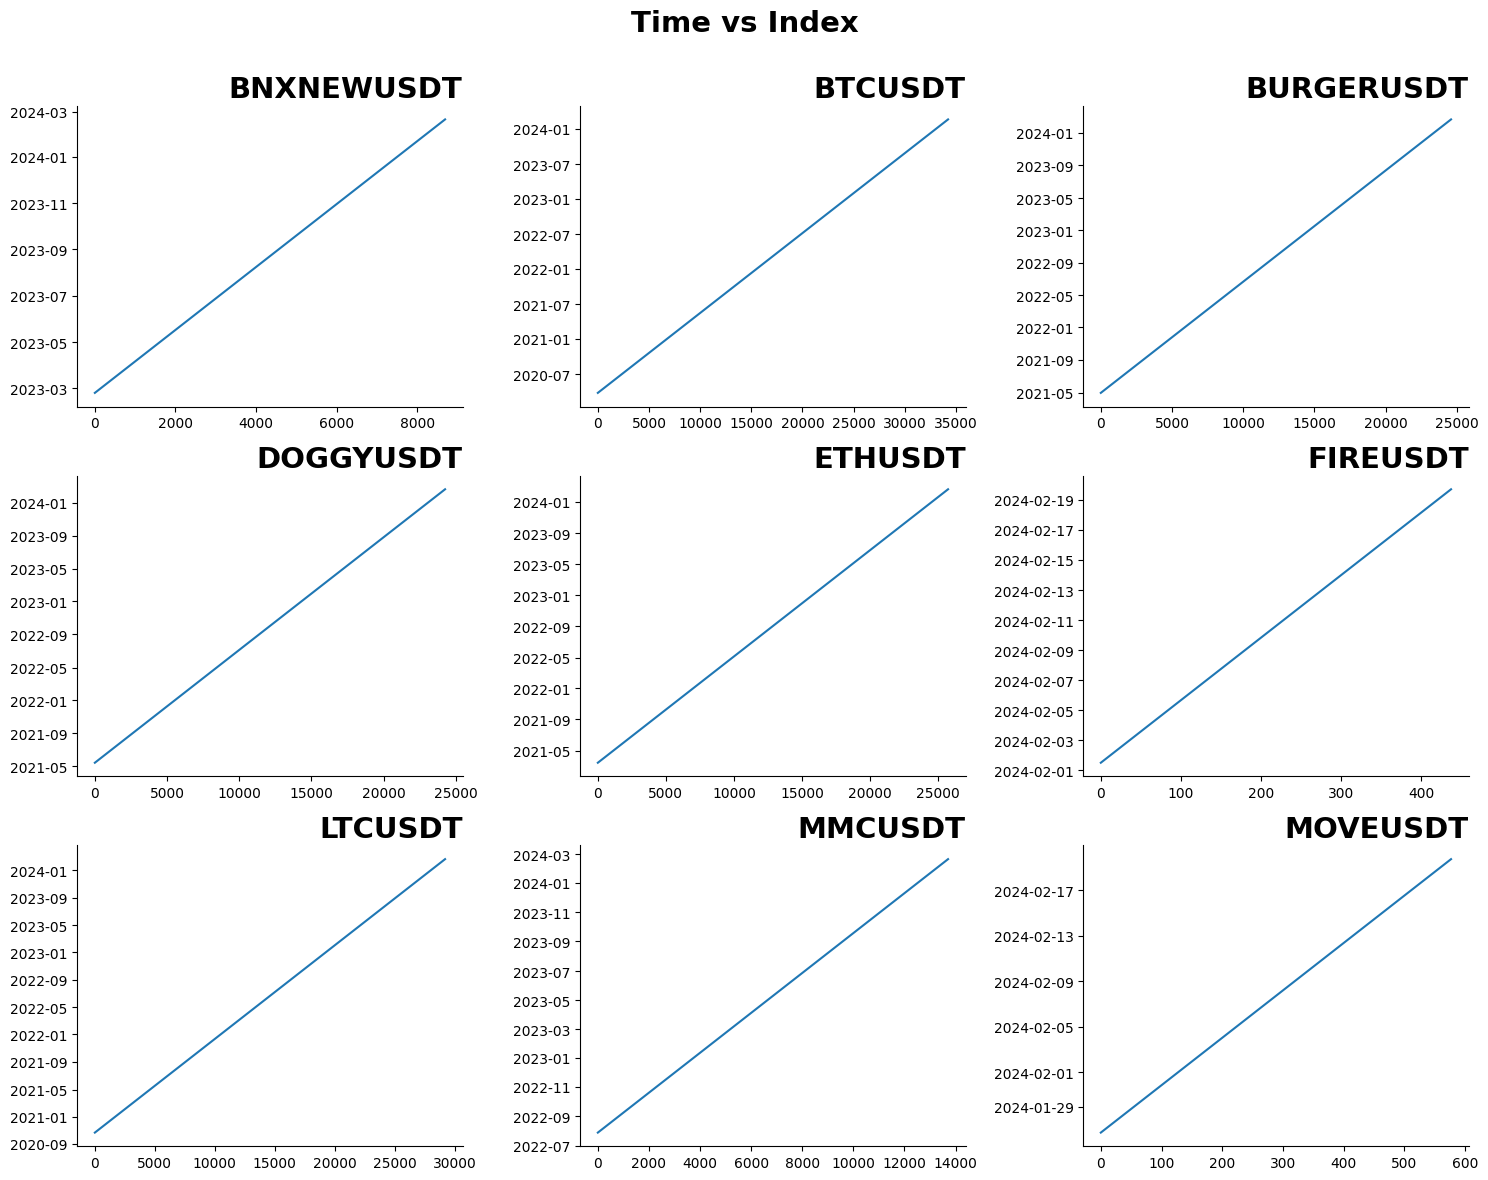

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare train data

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    # drop features that show direction (like macd_dir or macd)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if 'up' in tmp_df_1h.columns:
                tmp_df_1h = tmp_df_1h.drop(columns=['up', 'down'])
            
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
            row['ticker'] = ticker
            row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            if close_price.shape[0] == 0:
                continue
            
            close_price = close_price.values[0]
            
            tmp_df_1h['up'] = 0
            tmp_df_1h['down'] = 0
            upper_price = close_price * CFG.cls_target_ratio_tp
            lower_price = close_price * (2 - CFG.cls_target_ratio_tp)

            tmp_df_1h.loc[(tmp_df_1h['real_high'] >= upper_price) & (tmp_df_1h['time'] > t), 'up'] = 1
            tmp_df_1h.loc[(tmp_df_1h['real_low'] <= lower_price) & (tmp_df_1h['time'] > t), 'down'] = 1

            # find the first index when price reach upper and the first index when price reach lower border
            up, down = tmp_df_1h['up'].idxmax(), tmp_df_1h['down'].idxmax()
            
            # if price didn't left the price up\down range - don't add this row
            up_max, down_max = tmp_df_1h['up'].max(), tmp_df_1h['down'].max()
            if up_max == down_max == 0:
                continue

            # pattern and ttype flags
            pattern = row['pattern'].values[0]
            ttype = row['ttype'].values[0]

            # if price moved as predicted - set target to 1
            if pattern.startswith('STOCH'):
                if ttype == 'buy' and (up_max == 0 or 0 < down < up):
                    row['target'] = 1
                elif ttype == 'sell' and (down_max == 0 or 0 < up < down):
                    row['target'] = 1
            else:
                if ttype == 'buy' and (down_max == 0 or 0 < up < down):
                    row['target'] = 1
                elif ttype == 'sell' and (up_max == 0 or 0 < down < up):
                    row['target'] = 1
            
            # # add aggregate features 
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df.reset_index(drop=True)

if CFG.create_dataset:
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
    price_cols = ['open','high', 'low', 'close']
    real_price_cols = ['real_high', 'real_low', 'real_close']
    funding_cols = ['funding_rate']
    rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
    btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
    btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    # select hours with the most target disbalance
    df = df[df['time'].dt.hour.isin([0, 1, 2, 3, 16, 17, 21, 22, 23])] 
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, first, last, step)
    train_buy = train_buy.dropna().sort_values('time').reset_index(drop=True)
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    
    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    # select hours with the most target disbalance
    df = df[df['time'].dt.hour.isin([2, 14, 17, 18, 19, 21, 22, 23])]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, first, last, step)
    train_sell = train_sell.dropna().sort_values('time').reset_index(drop=True)
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    display(train_sell.head())
    display(train_sell.shape)

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin([2])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin([2])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)


error while signin
you are using nologin method, data you access may be limited


  0%|          | 0/1208 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,btcdom_close_prev_40,btcdom_volume_prev_40,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_diff_prev_44,atr_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macdsignal_prev_44,btcdom_open_prev_44,btc

(13249, 1015)

  0%|          | 0/1083 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,btcdom_close_prev_40,btcdom_volume_prev_40,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_diff_prev_44,atr_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macdsignal_prev_44,btcdom_open_prev_44,btc

(7649, 1015)

  0%|          | 0/694 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

# Create train dataset

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    train_df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    train_df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    train_df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = train_df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

del df


# Data tests

### Test train dataframe columns

In [9]:
import re

# check if train dataset has only columns that we expect
cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                    btcd_cols + btcdom_cols + ['atr', 'pattern', 'target', 'ticker', 'ttype', 'volume'])
assert expected_cols == cols

# check RSI and STOCH columns, their values must be in [0, 100] range 
rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
for r_s_c in rsi_stoch_cols_:
    assert train_df[r_s_c].min() > -0.0001
    assert train_df[r_s_c].max() < 100.0001

# check volume columns, their values must be >= 0
vol_cols_ = [c for c in train_df.columns if 'volume' in c]
for v_c in vol_cols_:
    assert train_df[v_c].min() >= 0

# check funding columns, their period must be 8 hours
funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
for f_c in funding_cols_:
    num = ''.join([i for i in f_c if i.isdigit()])
    if len(num) > 0:
        num = int(num)
        assert num % 8 == 0

# check BTC dominance columns, their values must be in [0, 100] range 
# and their period must be 24 hours
btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
for b_c in btcd_cols_:
    # check values
    assert train_df[b_c].min() >= 0
    assert train_df[b_c].max() <= 100
    # check period
    num = ''.join([i for i in b_c if i.isdigit()])
    if len(num) > 0:
        num = int(num)
        assert num % 24 == 0

# check the rest columns, their period must be 4 hours
rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
for r_c in rest_cols_:
    num = ''.join([i for i in r_c if i.isdigit()])
    if len(num) > 0:
        num = int(num)
        assert num % 4 == 0

# check if changing of source dataframe doesn't affect the resulting train dataframe
test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin([0])]
assert test_df_buy_1.shape == test_df_buy_2.shape
test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin([0])]
assert test_df_sell_1.shape == test_df_sell_2.shape

# plot time values 
train_df['time'].plot(title='Signal Time distribution')

AssertionError: 


### Test buy target corectness

In [10]:
if CFG.create_dataset:
    prev_ticker = None
    
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        low_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * (2 - CFG.cls_target_ratio_tp)
        high_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]

        tmp_df_1h = tmp_df_1h.iloc[idx+1:][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] <= tmp_df_1h['low_price'] 
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] >= tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            try:
                assert target == 0
            except:
                print(pattern, ticker, time_, target)
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal >= first_anti_signal

  0%|          | 0/13249 [00:00<?, ?it/s]

### Test sell target corectness

In [11]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        low_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * (2 - CFG.cls_target_ratio_tp)
        high_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0] * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]

        tmp_df_1h = tmp_df_1h.iloc[idx+1:][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

        tmp_df_1h['signal'] = tmp_df_1h['high'] >= tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] <= tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal >= first_anti_signal

  0%|          | 0/7649 [00:00<?, ?it/s]

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

if CFG.create_dataset:
    pvt = train_buy
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

    print('Buy')
    # display(pvt)
    display(pvt[pvt['pct'] >= 0.517])
    display(train_buy['ttype'].value_counts())
    display(train_buy[['target', 'pattern']].value_counts())
    display(train_buy[['target', 'pattern']].value_counts(normalize=True))

    pvt = train_sell
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

    print('Sell')
    # display(pvt)
    display(pvt[pvt['pct'] >= 0.517])
    display(train_sell['ttype'].value_counts())
    display(train_sell[['target', 'pattern']].value_counts())
    display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,706,1259,0.560763,"(0.5335, 0.588)"
3,1,1,861,1608,0.535448,"(0.5112, 0.5597)"
5,2,1,808,1527,0.529142,"(0.5042, 0.5541)"
7,3,1,938,1802,0.520533,"(0.4976, 0.5435)"
9,16,1,765,1409,0.542938,"(0.5171, 0.5688)"
11,17,1,753,1425,0.528421,"(0.5026, 0.5542)"
13,21,1,797,1473,0.541073,"(0.5158, 0.5664)"
15,22,1,820,1480,0.554054,"(0.5289, 0.5792)"
17,23,1,718,1266,0.567141,"(0.54, 0.5943)"


buy    13249
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7166
0       STOCH_RSI_Volume24    6083
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.540871
0       STOCH_RSI_Volume24    0.459129
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,2,1,516,994,0.519115,"(0.4882, 0.55)"
3,14,1,697,1313,0.530845,"(0.504, 0.5577)"
5,17,1,489,879,0.556314,"(0.5236, 0.589)"
7,18,1,434,834,0.520384,"(0.4867, 0.5541)"
9,19,1,452,867,0.521338,"(0.4883, 0.5544)"
11,21,1,501,928,0.539871,"(0.508, 0.5718)"
13,22,1,464,890,0.521348,"(0.4887, 0.554)"
15,23,1,513,944,0.543432,"(0.5118, 0.575)"


sell    7649
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    4066
0       STOCH_RSI_Volume24    3583
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.531573
0       STOCH_RSI_Volume24    0.468427
dtype: float64

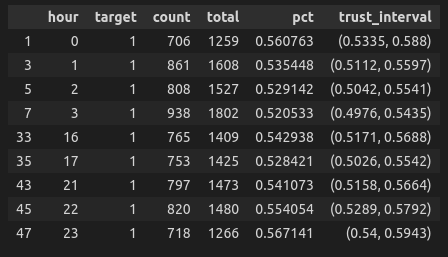

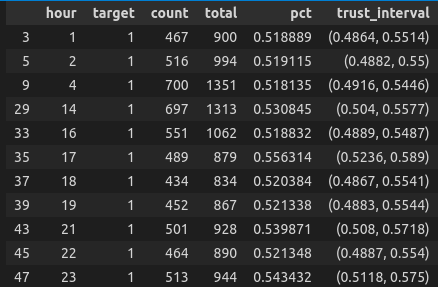

# Data visualization

### Visualize buy trades

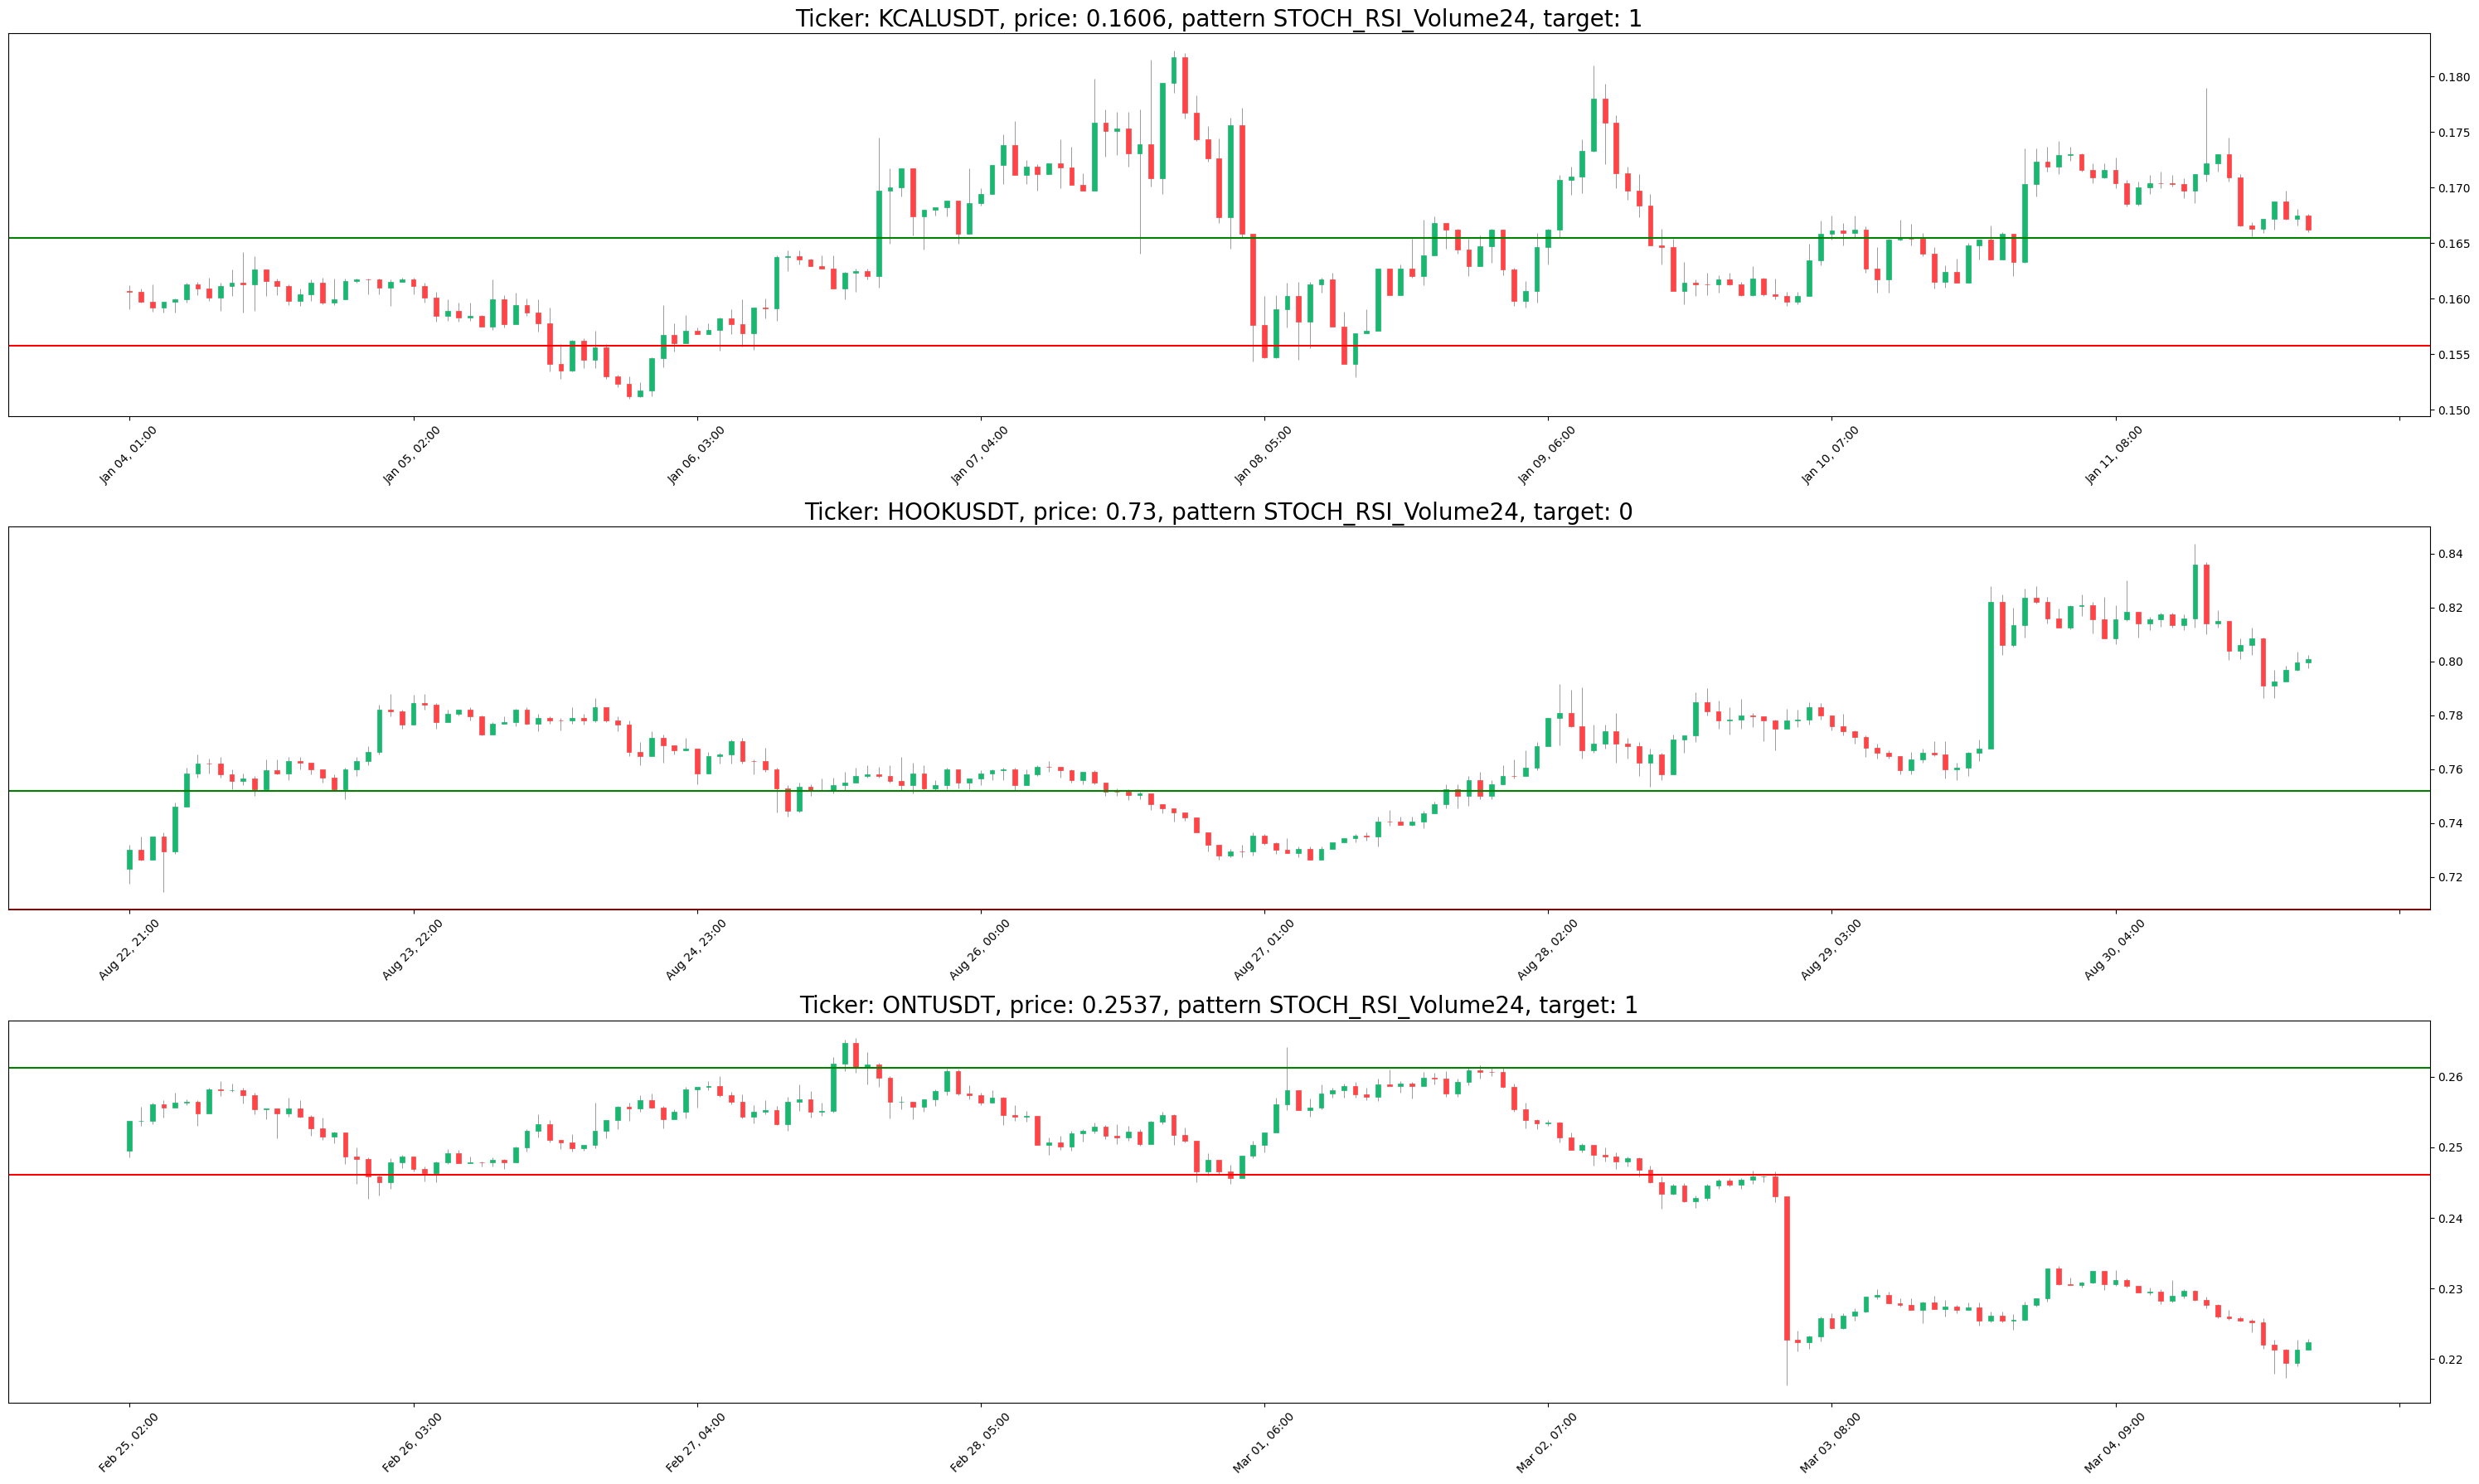

In [14]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    target_offset = 192
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

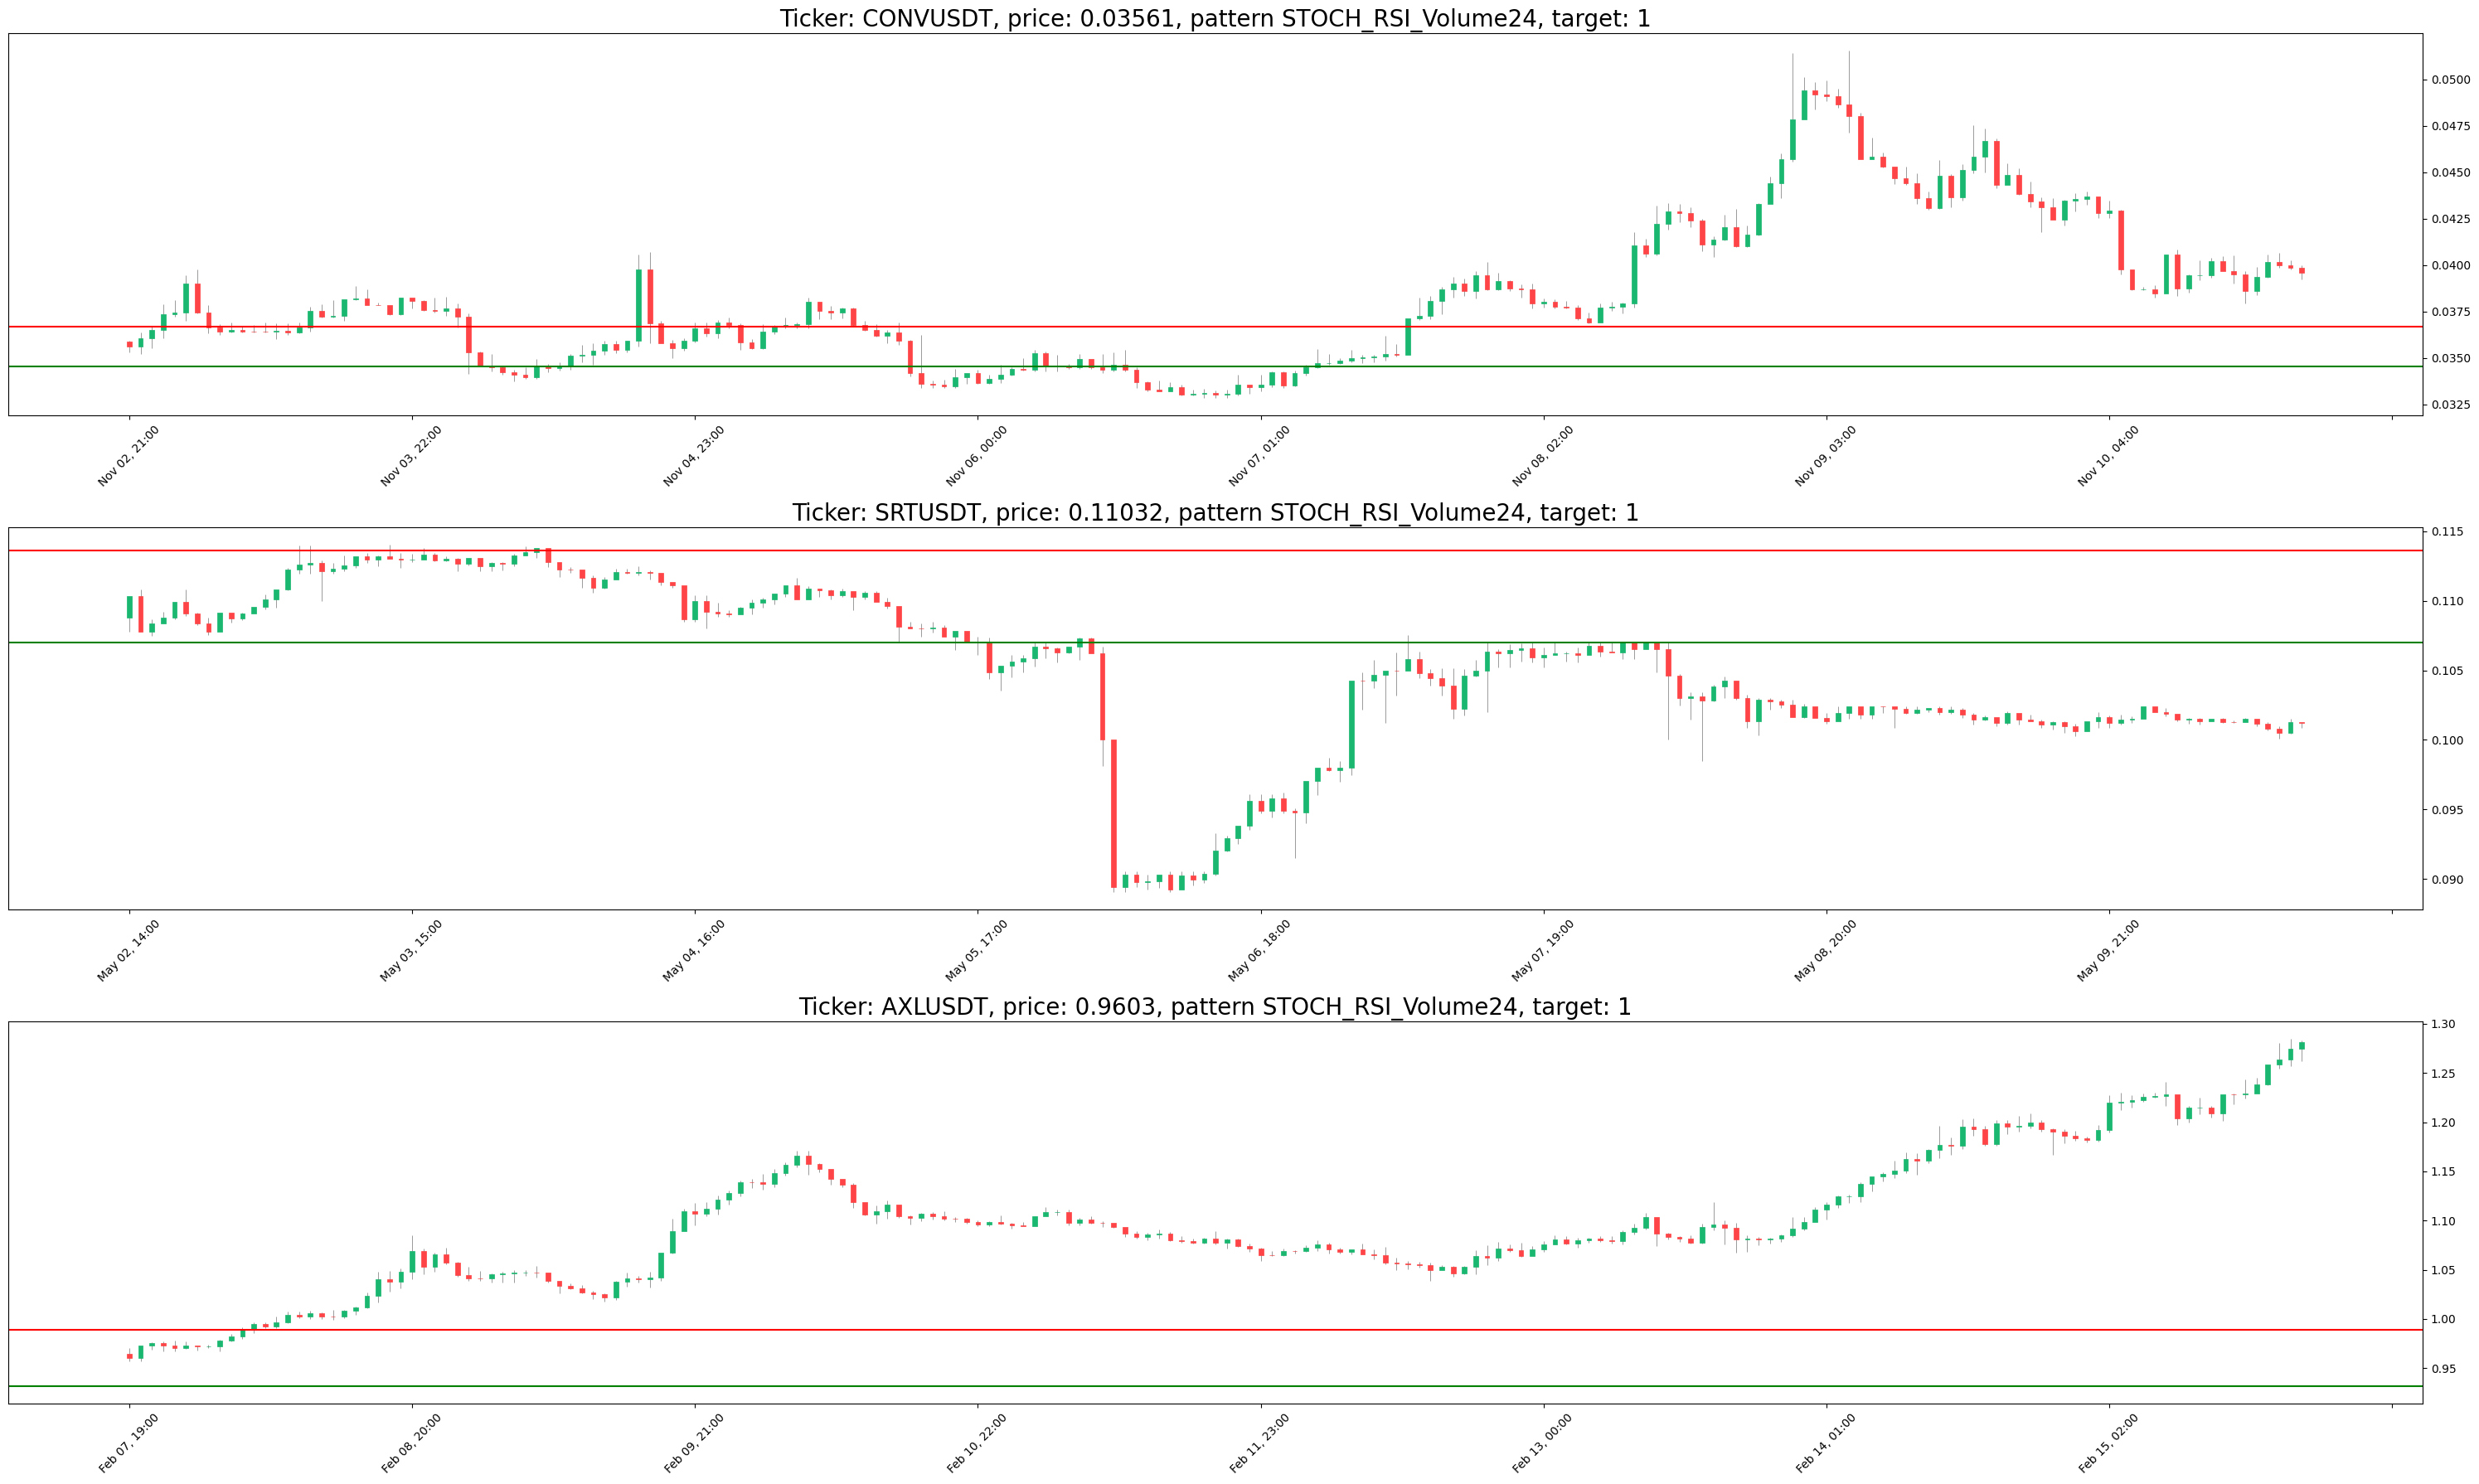

In [15]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

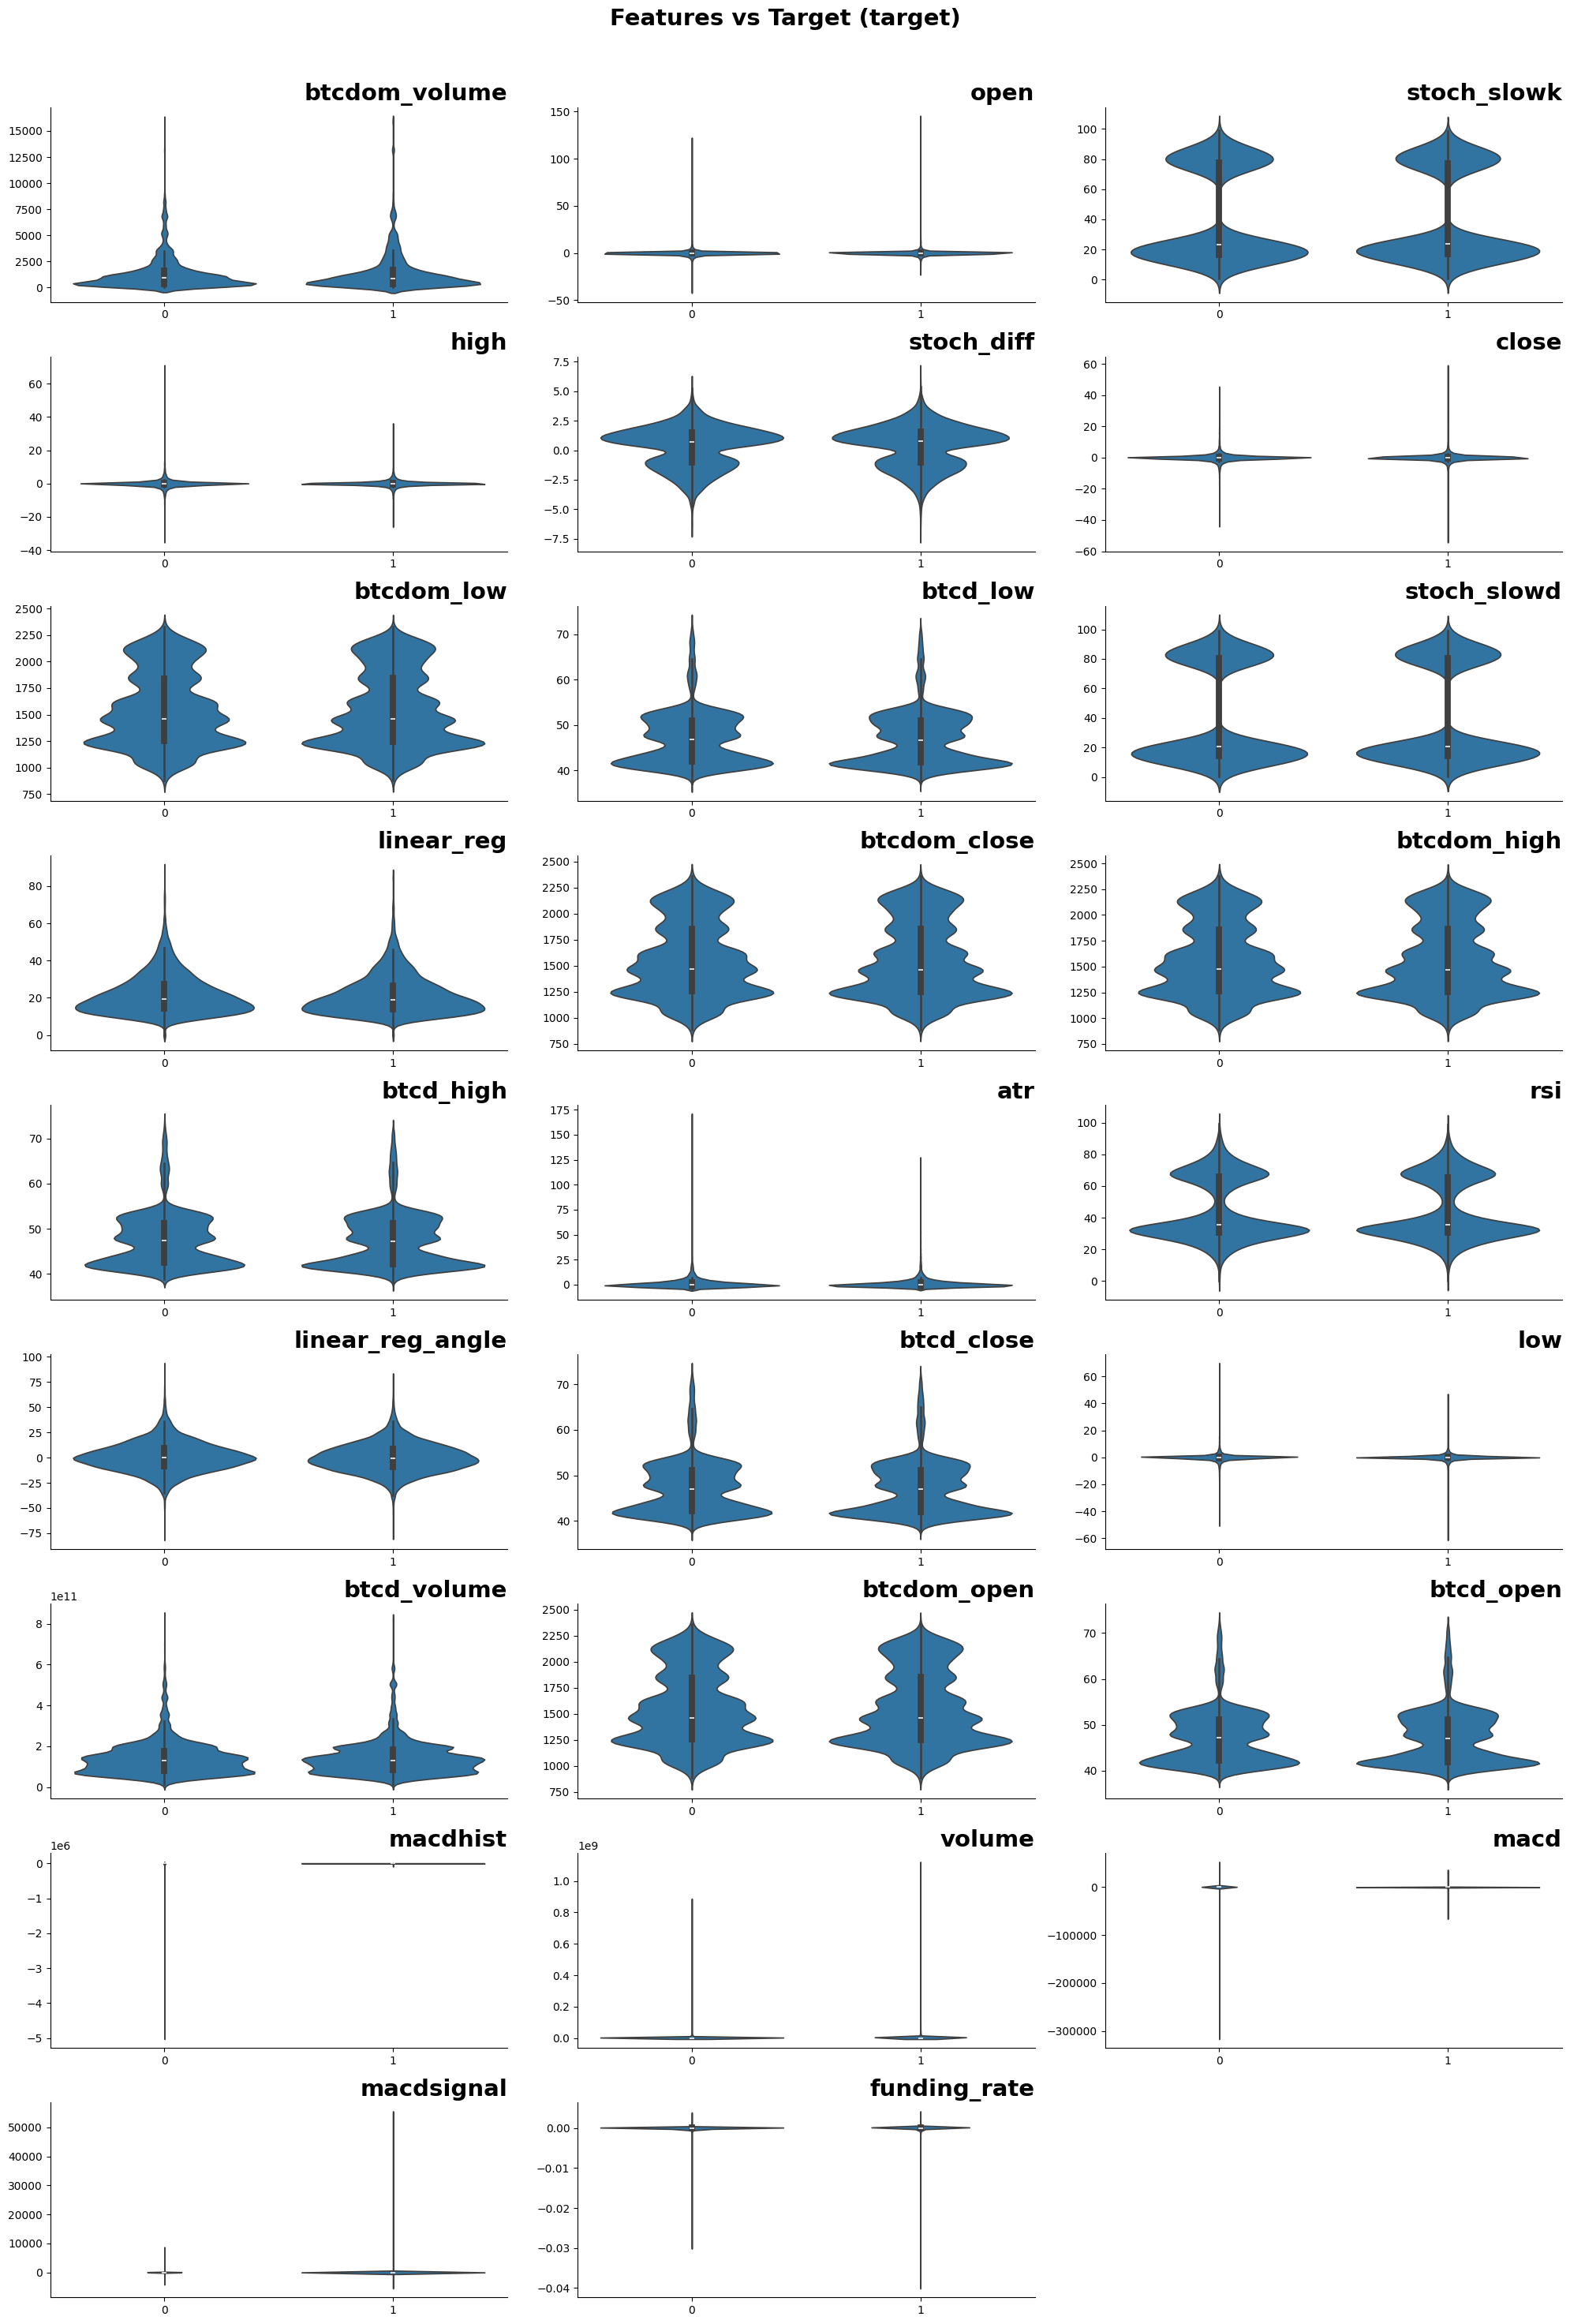

In [16]:
fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target') 

### Show the last signals

In [17]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
# x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
73533,2024-02-19 14:00:00,MINDUSDT,buy,STOCH_RSI_Volume24
73534,2024-02-19 14:00:00,PERPUSDT,sell,STOCH_RSI_Volume24
73535,2024-02-19 14:00:00,CGPTUSDT,sell,STOCH_RSI_Volume24
73536,2024-02-19 14:00:00,FORTUSDT,sell,STOCH_RSI_Volume24
73537,2024-02-19 14:00:00,WOIDUSDT,sell,STOCH_RSI_Volume24
73538,2024-02-19 14:00:00,PHBUSDT,sell,STOCH_RSI_Volume24
73539,2024-02-19 14:00:00,PEOPLEUSDT,sell,STOCH_RSI_Volume24
73540,2024-02-19 14:00:00,SAUCEUSDT,sell,STOCH_RSI_Volume24
73541,2024-02-19 14:00:00,GOGUSDT,sell,STOCH_RSI_Volume24
73542,2024-02-19 14:00:00,FILECOIN_USDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [18]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=400)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [19]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [21]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

### Load selected features

In [22]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 430
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['btcdom_volume',
 'open',
 'stoch_slowk',
 'high',
 'stoch_diff',
 'close',
 'btcdom_low',
 'btcd_low',
 'stoch_slowd',
 'linear_reg',
 'btcdom_close',
 'btcdom_high',
 'btcd_high',
 'atr',
 'rsi',
 'linear_reg_angle',
 'btcd_close',
 'low',
 'low_prev_4',
 'atr_prev_4',
 'linear_reg_angle_prev_4',
 'close_prev_4',
 'stoch_slowd_prev_4',
 'volume_prev_4',
 'stoch_slowk_prev_4',
 'rsi_prev_4',
 'stoch_diff_prev_4',
 'btcdom_volume_prev_4',
 'btcdom_close_prev_4',
 'linear_reg_prev_4',
 'btcdom_volume_prev_8',
 'close_prev_8',
 'volume_prev_8',
 'low_prev_8',
 'rsi_prev_8',
 'stoch_diff_prev_8',
 'close_prev_12',
 'stoch_slowd_prev_12',
 'rsi_prev_12',
 'low_prev_12',
 'btcdom_low_prev_12',
 'btcdom_high_prev_12',
 'btcdom_volume_prev_12',
 'low_prev_16',
 'btcdom_volume_prev_16',
 'stoch_slowd_prev_16',
 'btcdom_open_prev_16',
 'btcdom_high_prev_16',
 'atr_prev_16',
 'btcdom_low_prev_16',
 'macdhist_prev_16',
 'stoch_diff_prev_16',
 'high_prev_16',
 'close_prev_16',
 'btcdom_volume_pre

### Show the features that correlate with other features too much (corr >= 0.8) and are not too important

In [23]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Train

### Functions for train and optimization

In [24]:
val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round(prec_obj_num * prec_score - prec_obj_num * (1 -prec_score))}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [25]:
params = {
    'boosting_type': 'goss',
    'n_estimators': 2935,
    'learning_rate': 0.000101,
    'max_depth': 10,
    'colsample_bytree': 0.86448,
    # 'subsample': 0.5394907029626385,
    'subsample_freq': 1,
    'num_leaves': 37,
    'verbosity': -1,
    'max_bin': 229,
    'reg_alpha': 0.050818,
    'reg_lambda': 2.192784e-08,
    'is_unbalance': True,
    'class_weight': 'balanced',
    'objective': 'binary',
    'importance_type': 'gain',
    'metric': 'average_precision'
    }

# params = {
#     'boosting_type': 'gbdt',
#     'n_estimators': 1126,
#     'learning_rate': 0.0035991755858287514,
#     'max_depth': 6,
#     'colsample_bytree': 0.7437349346323546,
#     'subsample': 0.5394907029626385,
#     'subsample_freq': 1,
#     'num_leaves': 237,
#     'verbosity': -1,
#     'max_bin': 117,
#     'reg_alpha': 0.0003694000166537471,
#     'reg_lambda': 9.820784723776928,
#     'is_unbalance': True,
#     'class_weight': 'balanced',
#     'objective': 'binary',
#     'importance_type': 'gain',
#     'metric': 'average_precision'
#     }

train_test = 'fold' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))}')
elif train_test == 'full':
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl')



    
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 431 features
Fold #1


1    0.541667
0    0.458333
Name: target, dtype: float64

Timestamp('2022-06-16 16:00:00')

Timestamp('2024-02-18 22:00:00')

[100]	training's binary_logloss: 0.691498	training's average_precision: 0.796568	valid_1's binary_logloss: 0.693282	valid_1's average_precision: 0.536674
[200]	training's binary_logloss: 0.68987	training's average_precision: 0.797012	valid_1's binary_logloss: 0.693459	valid_1's average_precision: 0.532795
[300]	training's binary_logloss: 0.68826	training's average_precision: 0.795904	valid_1's binary_logloss: 0.693623	valid_1's average_precision: 0.533557
[400]	training's binary_logloss: 0.686686	training's average_precision: 0.795618	valid_1's binary_logloss: 0.693759	valid_1's average_precision: 0.535033
[500]	training's binary_logloss: 0.685136	training's average_precision: 0.796778	valid_1's binary_logloss: 0.693935	valid_1's average_precision: 0.534633
[600]	training's binary_logloss: 0.683597	training's average_precision: 0.798924	valid_1's binary_logloss: 0.693967	valid_1's average_precision: 0.538636
[700]	training's binary_logloss: 0.682074	training's average_precision: 0.8001

1    0.541054
0    0.458946
Name: target, dtype: float64

Timestamp('2022-11-13 17:00:00')

Timestamp('2024-02-18 22:00:00')

[100]	training's binary_logloss: 0.69182	training's average_precision: 0.759205	valid_1's binary_logloss: 0.693191	valid_1's average_precision: 0.529931
[200]	training's binary_logloss: 0.690509	training's average_precision: 0.765321	valid_1's binary_logloss: 0.693231	valid_1's average_precision: 0.527824
[300]	training's binary_logloss: 0.689218	training's average_precision: 0.764729	valid_1's binary_logloss: 0.693345	valid_1's average_precision: 0.525073
[400]	training's binary_logloss: 0.687946	training's average_precision: 0.765156	valid_1's binary_logloss: 0.693483	valid_1's average_precision: 0.523018
[500]	training's binary_logloss: 0.686685	training's average_precision: 0.767655	valid_1's binary_logloss: 0.693598	valid_1's average_precision: 0.52201
[600]	training's binary_logloss: 0.685443	training's average_precision: 0.769516	valid_1's binary_logloss: 0.693695	valid_1's average_precision: 0.522662
[700]	training's binary_logloss: 0.684216	training's average_precision: 0.7714

1    0.546759
0    0.453241
Name: target, dtype: float64

Timestamp('2023-04-17 23:00:00')

Timestamp('2024-02-18 22:00:00')

[100]	training's binary_logloss: 0.691906	training's average_precision: 0.757302	valid_1's binary_logloss: 0.693191	valid_1's average_precision: 0.563872
[200]	training's binary_logloss: 0.690672	training's average_precision: 0.761459	valid_1's binary_logloss: 0.69322	valid_1's average_precision: 0.563276
[300]	training's binary_logloss: 0.689465	training's average_precision: 0.759667	valid_1's binary_logloss: 0.693271	valid_1's average_precision: 0.562344
[400]	training's binary_logloss: 0.688278	training's average_precision: 0.759873	valid_1's binary_logloss: 0.693343	valid_1's average_precision: 0.56203
[500]	training's binary_logloss: 0.6871	training's average_precision: 0.761146	valid_1's binary_logloss: 0.693414	valid_1's average_precision: 0.562358
[600]	training's binary_logloss: 0.685942	training's average_precision: 0.76207	valid_1's binary_logloss: 0.693497	valid_1's average_precision: 0.561955
[700]	training's binary_logloss: 0.684797	training's average_precision: 0.763558	

1    0.568685
0    0.431315
Name: target, dtype: float64

Timestamp('2023-08-08 19:00:00')

Timestamp('2024-02-18 22:00:00')

[100]	training's binary_logloss: 0.692013	training's average_precision: 0.73953	valid_1's binary_logloss: 0.693252	valid_1's average_precision: 0.597642
[200]	training's binary_logloss: 0.690885	training's average_precision: 0.744541	valid_1's binary_logloss: 0.693419	valid_1's average_precision: 0.594692
[300]	training's binary_logloss: 0.689783	training's average_precision: 0.743077	valid_1's binary_logloss: 0.69357	valid_1's average_precision: 0.594555
[400]	training's binary_logloss: 0.688698	training's average_precision: 0.743146	valid_1's binary_logloss: 0.693745	valid_1's average_precision: 0.593396
[500]	training's binary_logloss: 0.687625	training's average_precision: 0.744123	valid_1's binary_logloss: 0.693868	valid_1's average_precision: 0.594847
[600]	training's binary_logloss: 0.686567	training's average_precision: 0.74485	valid_1's binary_logloss: 0.694045	valid_1's average_precision: 0.592948
[700]	training's binary_logloss: 0.685515	training's average_precision: 0.74601

1    0.558824
0    0.441176
Name: target, dtype: float64

Timestamp('2023-12-01 17:00:00')

Timestamp('2024-02-18 22:00:00')

[100]	training's binary_logloss: 0.692132	training's average_precision: 0.727566	valid_1's binary_logloss: 0.69306	valid_1's average_precision: 0.586825
[200]	training's binary_logloss: 0.691128	training's average_precision: 0.730421	valid_1's binary_logloss: 0.692999	valid_1's average_precision: 0.582771
[300]	training's binary_logloss: 0.690139	training's average_precision: 0.730173	valid_1's binary_logloss: 0.6929	valid_1's average_precision: 0.582077
[400]	training's binary_logloss: 0.689166	training's average_precision: 0.729872	valid_1's binary_logloss: 0.692805	valid_1's average_precision: 0.581214
[500]	training's binary_logloss: 0.688207	training's average_precision: 0.729933	valid_1's binary_logloss: 0.69271	valid_1's average_precision: 0.582837
[600]	training's binary_logloss: 0.687264	training's average_precision: 0.73047	valid_1's binary_logloss: 0.692591	valid_1's average_precision: 0.584729
[700]	training's binary_logloss: 0.686332	training's average_precision: 0.731302	

In [26]:
# Training with 431 features
# Fold #1
# 1    0.541667
# 0    0.458333
# Name: target, dtype: float64Timestamp('2022-06-16 16:00:00')Timestamp('2024-02-18 22:00:00')
# [100]	training's binary_logloss: 0.691498	training's average_precision: 0.796568	valid_1's binary_logloss: 0.693282	valid_1's average_precision: 0.536674
# [200]	training's binary_logloss: 0.68987	training's average_precision: 0.797012	valid_1's binary_logloss: 0.693459	valid_1's average_precision: 0.532795
# [300]	training's binary_logloss: 0.68826	training's average_precision: 0.795904	valid_1's binary_logloss: 0.693623	valid_1's average_precision: 0.533557
# [400]	training's binary_logloss: 0.686686	training's average_precision: 0.795618	valid_1's binary_logloss: 0.693759	valid_1's average_precision: 0.535033
# [500]	training's binary_logloss: 0.685136	training's average_precision: 0.796778	valid_1's binary_logloss: 0.693935	valid_1's average_precision: 0.534633
# [600]	training's binary_logloss: 0.683597	training's average_precision: 0.798924	valid_1's binary_logloss: 0.693967	valid_1's average_precision: 0.538636
# [700]	training's binary_logloss: 0.682074	training's average_precision: 0.800133	valid_1's binary_logloss: 0.693995	valid_1's average_precision: 0.540826
# [800]	training's binary_logloss: 0.680572	training's average_precision: 0.802231	valid_1's binary_logloss: 0.693965	valid_1's average_precision: 0.542634
# [900]	training's binary_logloss: 0.679094	training's average_precision: 0.80455	valid_1's binary_logloss: 0.693962	valid_1's average_precision: 0.543286
# [1000]	training's binary_logloss: 0.677657	training's average_precision: 0.807219	valid_1's binary_logloss: 0.693982	valid_1's average_precision: 0.54424
# [1100]	training's binary_logloss: 0.676241	training's average_precision: 0.809292	valid_1's binary_logloss: 0.69398	valid_1's average_precision: 0.545262
# [1200]	training's binary_logloss: 0.67484	training's average_precision: 0.810963	valid_1's binary_logloss: 0.693972	valid_1's average_precision: 0.545491
# [1300]	training's binary_logloss: 0.673452	training's average_precision: 0.812364	valid_1's binary_logloss: 0.693968	valid_1's average_precision: 0.545996
# [1400]	training's binary_logloss: 0.67208	training's average_precision: 0.813549	valid_1's binary_logloss: 0.694017	valid_1's average_precision: 0.545397
# [1500]	training's binary_logloss: 0.670723	training's average_precision: 0.814653	valid_1's binary_logloss: 0.694085	valid_1's average_precision: 0.543549
# [1600]	training's binary_logloss: 0.669381	training's average_precision: 0.815408	valid_1's binary_logloss: 0.694144	valid_1's average_precision: 0.541951
# [1700]	training's binary_logloss: 0.668065	training's average_precision: 0.816038	valid_1's binary_logloss: 0.694213	valid_1's average_precision: 0.540349
# [1800]	training's binary_logloss: 0.666751	training's average_precision: 0.816739	valid_1's binary_logloss: 0.694232	valid_1's average_precision: 0.541022
# [1900]	training's binary_logloss: 0.665459	training's average_precision: 0.817386	valid_1's binary_logloss: 0.694269	valid_1's average_precision: 0.541562
# [2000]	training's binary_logloss: 0.664181	training's average_precision: 0.818086	valid_1's binary_logloss: 0.69428	valid_1's average_precision: 0.542623
# [2100]	training's binary_logloss: 0.662913	training's average_precision: 0.818812	valid_1's binary_logloss: 0.694314	valid_1's average_precision: 0.542952
# [2200]	training's binary_logloss: 0.661659	training's average_precision: 0.819576	valid_1's binary_logloss: 0.694372	valid_1's average_precision: 0.542971
# [2300]	training's binary_logloss: 0.660417	training's average_precision: 0.820215	valid_1's binary_logloss: 0.694399	valid_1's average_precision: 0.543792
# [2400]	training's binary_logloss: 0.659181	training's average_precision: 0.82082	valid_1's binary_logloss: 0.694409	valid_1's average_precision: 0.544688
# [2500]	training's binary_logloss: 0.657967	training's average_precision: 0.821514	valid_1's binary_logloss: 0.69446	valid_1's average_precision: 0.545419
# [2600]	training's binary_logloss: 0.656758	training's average_precision: 0.822169	valid_1's binary_logloss: 0.694474	valid_1's average_precision: 0.546188
# [2700]	training's binary_logloss: 0.655561	training's average_precision: 0.822691	valid_1's binary_logloss: 0.69453	valid_1's average_precision: 0.546517
# [2800]	training's binary_logloss: 0.654396	training's average_precision: 0.823404	valid_1's binary_logloss: 0.69457	valid_1's average_precision: 0.547078
# [2900]	training's binary_logloss: 0.653233	training's average_precision: 0.824393	valid_1's binary_logloss: 0.694602	valid_1's average_precision: 0.547442
# Logloss: 0.6946194275096063, Confident objects precision: 0.5326905694486291
# Number of confident objects 3319, % of confident objects: 0.4640659955257271
# Number of profitable objects: 217
# Fold #2
# 1    0.541054
# 0    0.458946
# Name: target, dtype: float64Timestamp('2022-11-13 17:00:00')Timestamp('2024-02-18 22:00:00')
# [100]	training's binary_logloss: 0.69182	training's average_precision: 0.759205	valid_1's binary_logloss: 0.693191	valid_1's average_precision: 0.529931
# [200]	training's binary_logloss: 0.690509	training's average_precision: 0.765321	valid_1's binary_logloss: 0.693231	valid_1's average_precision: 0.527824
# [300]	training's binary_logloss: 0.689218	training's average_precision: 0.764729	valid_1's binary_logloss: 0.693345	valid_1's average_precision: 0.525073
# [400]	training's binary_logloss: 0.687946	training's average_precision: 0.765156	valid_1's binary_logloss: 0.693483	valid_1's average_precision: 0.523018
# [500]	training's binary_logloss: 0.686685	training's average_precision: 0.767655	valid_1's binary_logloss: 0.693598	valid_1's average_precision: 0.52201
# [600]	training's binary_logloss: 0.685443	training's average_precision: 0.769516	valid_1's binary_logloss: 0.693695	valid_1's average_precision: 0.522662
# [700]	training's binary_logloss: 0.684216	training's average_precision: 0.771467	valid_1's binary_logloss: 0.693762	valid_1's average_precision: 0.523583
# [800]	training's binary_logloss: 0.683006	training's average_precision: 0.772534	valid_1's binary_logloss: 0.693847	valid_1's average_precision: 0.524752
# [900]	training's binary_logloss: 0.681812	training's average_precision: 0.773335	valid_1's binary_logloss: 0.693972	valid_1's average_precision: 0.524005
# [1000]	training's binary_logloss: 0.680635	training's average_precision: 0.774062	valid_1's binary_logloss: 0.694053	valid_1's average_precision: 0.524773
# [1100]	training's binary_logloss: 0.679477	training's average_precision: 0.774637	valid_1's binary_logloss: 0.694134	valid_1's average_precision: 0.525976
# [1200]	training's binary_logloss: 0.678328	training's average_precision: 0.77538	valid_1's binary_logloss: 0.694232	valid_1's average_precision: 0.526015
# [1300]	training's binary_logloss: 0.677191	training's average_precision: 0.776215	valid_1's binary_logloss: 0.694264	valid_1's average_precision: 0.527219
# [1400]	training's binary_logloss: 0.676064	training's average_precision: 0.777077	valid_1's binary_logloss: 0.69432	valid_1's average_precision: 0.527293
# [1500]	training's binary_logloss: 0.674951	training's average_precision: 0.777837	valid_1's binary_logloss: 0.694371	valid_1's average_precision: 0.527814
# [1600]	training's binary_logloss: 0.673854	training's average_precision: 0.778532	valid_1's binary_logloss: 0.694424	valid_1's average_precision: 0.528779
# [1700]	training's binary_logloss: 0.67277	training's average_precision: 0.779342	valid_1's binary_logloss: 0.694481	valid_1's average_precision: 0.529056
# [1800]	training's binary_logloss: 0.671692	training's average_precision: 0.780382	valid_1's binary_logloss: 0.694526	valid_1's average_precision: 0.529115
# [1900]	training's binary_logloss: 0.670627	training's average_precision: 0.781368	valid_1's binary_logloss: 0.694555	valid_1's average_precision: 0.529431
# [2000]	training's binary_logloss: 0.669577	training's average_precision: 0.782329	valid_1's binary_logloss: 0.694607	valid_1's average_precision: 0.529682
# [2100]	training's binary_logloss: 0.668538	training's average_precision: 0.783129	valid_1's binary_logloss: 0.69463	valid_1's average_precision: 0.529992
# [2200]	training's binary_logloss: 0.667509	training's average_precision: 0.784055	valid_1's binary_logloss: 0.694679	valid_1's average_precision: 0.530502
# [2300]	training's binary_logloss: 0.666489	training's average_precision: 0.785005	valid_1's binary_logloss: 0.694787	valid_1's average_precision: 0.53112
# [2400]	training's binary_logloss: 0.665484	training's average_precision: 0.785834	valid_1's binary_logloss: 0.694884	valid_1's average_precision: 0.531482
# [2500]	training's binary_logloss: 0.664497	training's average_precision: 0.786681	valid_1's binary_logloss: 0.694984	valid_1's average_precision: 0.531715
# [2600]	training's binary_logloss: 0.663518	training's average_precision: 0.787506	valid_1's binary_logloss: 0.695119	valid_1's average_precision: 0.531947
# [2700]	training's binary_logloss: 0.662553	training's average_precision: 0.788332	valid_1's binary_logloss: 0.695185	valid_1's average_precision: 0.531881
# [2800]	training's binary_logloss: 0.661604	training's average_precision: 0.788764	valid_1's binary_logloss: 0.695277	valid_1's average_precision: 0.532228
# [2900]	training's binary_logloss: 0.660652	training's average_precision: 0.789499	valid_1's binary_logloss: 0.695381	valid_1's average_precision: 0.532422
# Logloss: 0.6954161446923317, Confident objects precision: 0.5233333333333333
# Number of confident objects 2400, % of confident objects: 0.41486603284356094
# Number of profitable objects: 112
# Fold #3
# 1    0.546759
# 0    0.453241
# Name: target, dtype: float64Timestamp('2023-04-17 23:00:00')Timestamp('2024-02-18 22:00:00')
# [100]	training's binary_logloss: 0.691906	training's average_precision: 0.757302	valid_1's binary_logloss: 0.693191	valid_1's average_precision: 0.563872
# [200]	training's binary_logloss: 0.690672	training's average_precision: 0.761459	valid_1's binary_logloss: 0.69322	valid_1's average_precision: 0.563276
# [300]	training's binary_logloss: 0.689465	training's average_precision: 0.759667	valid_1's binary_logloss: 0.693271	valid_1's average_precision: 0.562344
# [400]	training's binary_logloss: 0.688278	training's average_precision: 0.759873	valid_1's binary_logloss: 0.693343	valid_1's average_precision: 0.56203
# [500]	training's binary_logloss: 0.6871	training's average_precision: 0.761146	valid_1's binary_logloss: 0.693414	valid_1's average_precision: 0.562358
# [600]	training's binary_logloss: 0.685942	training's average_precision: 0.76207	valid_1's binary_logloss: 0.693497	valid_1's average_precision: 0.561955
# [700]	training's binary_logloss: 0.684797	training's average_precision: 0.763558	valid_1's binary_logloss: 0.693579	valid_1's average_precision: 0.561072
# [800]	training's binary_logloss: 0.683673	training's average_precision: 0.764219	valid_1's binary_logloss: 0.693653	valid_1's average_precision: 0.560219
# [900]	training's binary_logloss: 0.682566	training's average_precision: 0.764661	valid_1's binary_logloss: 0.693735	valid_1's average_precision: 0.559345
# [1000]	training's binary_logloss: 0.681467	training's average_precision: 0.765292	valid_1's binary_logloss: 0.693838	valid_1's average_precision: 0.558025
# [1100]	training's binary_logloss: 0.680386	training's average_precision: 0.765883	valid_1's binary_logloss: 0.693932	valid_1's average_precision: 0.557461
# [1200]	training's binary_logloss: 0.679316	training's average_precision: 0.766537	valid_1's binary_logloss: 0.694	valid_1's average_precision: 0.558247
# [1300]	training's binary_logloss: 0.678227	training's average_precision: 0.769006	valid_1's binary_logloss: 0.69388	valid_1's average_precision: 0.562065
# [1400]	training's binary_logloss: 0.677149	training's average_precision: 0.770753	valid_1's binary_logloss: 0.69378	valid_1's average_precision: 0.564192
# [1500]	training's binary_logloss: 0.676087	training's average_precision: 0.77188	valid_1's binary_logloss: 0.693655	valid_1's average_precision: 0.567351
# [1600]	training's binary_logloss: 0.67503	training's average_precision: 0.772995	valid_1's binary_logloss: 0.69353	valid_1's average_precision: 0.572115
# [1700]	training's binary_logloss: 0.673988	training's average_precision: 0.773677	valid_1's binary_logloss: 0.693439	valid_1's average_precision: 0.575902
# [1800]	training's binary_logloss: 0.672976	training's average_precision: 0.774386	valid_1's binary_logloss: 0.693366	valid_1's average_precision: 0.578485
# [1900]	training's binary_logloss: 0.671977	training's average_precision: 0.774981	valid_1's binary_logloss: 0.69329	valid_1's average_precision: 0.579622
# [2000]	training's binary_logloss: 0.670983	training's average_precision: 0.775565	valid_1's binary_logloss: 0.693212	valid_1's average_precision: 0.579459
# [2100]	training's binary_logloss: 0.669999	training's average_precision: 0.776157	valid_1's binary_logloss: 0.693153	valid_1's average_precision: 0.578243
# [2200]	training's binary_logloss: 0.669032	training's average_precision: 0.776668	valid_1's binary_logloss: 0.693097	valid_1's average_precision: 0.577853
# [2300]	training's binary_logloss: 0.668073	training's average_precision: 0.777146	valid_1's binary_logloss: 0.693058	valid_1's average_precision: 0.577018
# [2400]	training's binary_logloss: 0.667126	training's average_precision: 0.777693	valid_1's binary_logloss: 0.693028	valid_1's average_precision: 0.57608
# [2500]	training's binary_logloss: 0.666184	training's average_precision: 0.778095	valid_1's binary_logloss: 0.692998	valid_1's average_precision: 0.575785
# [2600]	training's binary_logloss: 0.66525	training's average_precision: 0.778413	valid_1's binary_logloss: 0.692972	valid_1's average_precision: 0.575739
# [2700]	training's binary_logloss: 0.66433	training's average_precision: 0.778742	valid_1's binary_logloss: 0.692959	valid_1's average_precision: 0.575969
# [2800]	training's binary_logloss: 0.663428	training's average_precision: 0.778985	valid_1's binary_logloss: 0.692943	valid_1's average_precision: 0.576297
# [2900]	training's binary_logloss: 0.662508	training's average_precision: 0.779443	valid_1's binary_logloss: 0.692974	valid_1's average_precision: 0.576213
# Logloss: 0.6929738643755657, Confident objects precision: 0.5599276345545002
# Number of confident objects 2211, % of confident objects: 0.5288208562544846
# Number of profitable objects: 265
# Fold #4
# 1    0.568685
# 0    0.431315
# Name: target, dtype: float64Timestamp('2023-08-08 19:00:00')Timestamp('2024-02-18 22:00:00')
# [100]	training's binary_logloss: 0.692013	training's average_precision: 0.73953	valid_1's binary_logloss: 0.693252	valid_1's average_precision: 0.597642
# [200]	training's binary_logloss: 0.690885	training's average_precision: 0.744541	valid_1's binary_logloss: 0.693419	valid_1's average_precision: 0.594692
# [300]	training's binary_logloss: 0.689783	training's average_precision: 0.743077	valid_1's binary_logloss: 0.69357	valid_1's average_precision: 0.594555
# [400]	training's binary_logloss: 0.688698	training's average_precision: 0.743146	valid_1's binary_logloss: 0.693745	valid_1's average_precision: 0.593396
# [500]	training's binary_logloss: 0.687625	training's average_precision: 0.744123	valid_1's binary_logloss: 0.693868	valid_1's average_precision: 0.594847
# [600]	training's binary_logloss: 0.686567	training's average_precision: 0.74485	valid_1's binary_logloss: 0.694045	valid_1's average_precision: 0.592948
# [700]	training's binary_logloss: 0.685515	training's average_precision: 0.746017	valid_1's binary_logloss: 0.694296	valid_1's average_precision: 0.590045
# [800]	training's binary_logloss: 0.684486	training's average_precision: 0.746653	valid_1's binary_logloss: 0.694489	valid_1's average_precision: 0.588805
# [900]	training's binary_logloss: 0.683468	training's average_precision: 0.747135	valid_1's binary_logloss: 0.694698	valid_1's average_precision: 0.586943
# [1000]	training's binary_logloss: 0.682457	training's average_precision: 0.74806	valid_1's binary_logloss: 0.694893	valid_1's average_precision: 0.586047
# [1100]	training's binary_logloss: 0.681455	training's average_precision: 0.74898	valid_1's binary_logloss: 0.695128	valid_1's average_precision: 0.584759
# [1200]	training's binary_logloss: 0.680471	training's average_precision: 0.749613	valid_1's binary_logloss: 0.69535	valid_1's average_precision: 0.584047
# [1300]	training's binary_logloss: 0.6795	training's average_precision: 0.750094	valid_1's binary_logloss: 0.695558	valid_1's average_precision: 0.583456
# [1400]	training's binary_logloss: 0.678542	training's average_precision: 0.750501	valid_1's binary_logloss: 0.695781	valid_1's average_precision: 0.582838
# [1500]	training's binary_logloss: 0.677596	training's average_precision: 0.750741	valid_1's binary_logloss: 0.695997	valid_1's average_precision: 0.58243
# [1600]	training's binary_logloss: 0.676662	training's average_precision: 0.750845	valid_1's binary_logloss: 0.696257	valid_1's average_precision: 0.581843
# [1700]	training's binary_logloss: 0.675739	training's average_precision: 0.750978	valid_1's binary_logloss: 0.696505	valid_1's average_precision: 0.581235
# [1800]	training's binary_logloss: 0.674826	training's average_precision: 0.751186	valid_1's binary_logloss: 0.696738	valid_1's average_precision: 0.580878
# [1900]	training's binary_logloss: 0.673926	training's average_precision: 0.75165	valid_1's binary_logloss: 0.69698	valid_1's average_precision: 0.580484
# [2000]	training's binary_logloss: 0.673039	training's average_precision: 0.751872	valid_1's binary_logloss: 0.697232	valid_1's average_precision: 0.579881
# [2100]	training's binary_logloss: 0.672157	training's average_precision: 0.752254	valid_1's binary_logloss: 0.697482	valid_1's average_precision: 0.579187
# [2200]	training's binary_logloss: 0.671285	training's average_precision: 0.752752	valid_1's binary_logloss: 0.697743	valid_1's average_precision: 0.578818
# [2300]	training's binary_logloss: 0.670419	training's average_precision: 0.753404	valid_1's binary_logloss: 0.698052	valid_1's average_precision: 0.577995
# [2400]	training's binary_logloss: 0.669554	training's average_precision: 0.754044	valid_1's binary_logloss: 0.698361	valid_1's average_precision: 0.577343
# [2500]	training's binary_logloss: 0.668706	training's average_precision: 0.754831	valid_1's binary_logloss: 0.698656	valid_1's average_precision: 0.577137
# [2600]	training's binary_logloss: 0.667853	training's average_precision: 0.755734	valid_1's binary_logloss: 0.698888	valid_1's average_precision: 0.577458
# [2700]	training's binary_logloss: 0.667013	training's average_precision: 0.75661	valid_1's binary_logloss: 0.699074	valid_1's average_precision: 0.577832
# [2800]	training's binary_logloss: 0.666192	training's average_precision: 0.757275	valid_1's binary_logloss: 0.69929	valid_1's average_precision: 0.578193
# [2900]	training's binary_logloss: 0.665365	training's average_precision: 0.758104	valid_1's binary_logloss: 0.699519	valid_1's average_precision: 0.578491
# Logloss: 0.6995854607236963, Confident objects precision: 0.6039603960396039
# Number of confident objects 202, % of confident objects: 0.07459379615952733
# Number of profitable objects: 42
# Fold #5
# 1    0.558824
# 0    0.441176
# Name: target, dtype: float64Timestamp('2023-12-01 17:00:00')Timestamp('2024-02-18 22:00:00')
# [100]	training's binary_logloss: 0.692132	training's average_precision: 0.727566	valid_1's binary_logloss: 0.69306	valid_1's average_precision: 0.586825
# [200]	training's binary_logloss: 0.691128	training's average_precision: 0.730421	valid_1's binary_logloss: 0.692999	valid_1's average_precision: 0.582771
# [300]	training's binary_logloss: 0.690139	training's average_precision: 0.730173	valid_1's binary_logloss: 0.6929	valid_1's average_precision: 0.582077
# [400]	training's binary_logloss: 0.689166	training's average_precision: 0.729872	valid_1's binary_logloss: 0.692805	valid_1's average_precision: 0.581214
# [500]	training's binary_logloss: 0.688207	training's average_precision: 0.729933	valid_1's binary_logloss: 0.69271	valid_1's average_precision: 0.582837
# [600]	training's binary_logloss: 0.687264	training's average_precision: 0.73047	valid_1's binary_logloss: 0.692591	valid_1's average_precision: 0.584729
# [700]	training's binary_logloss: 0.686332	training's average_precision: 0.731302	valid_1's binary_logloss: 0.692478	valid_1's average_precision: 0.586938
# [800]	training's binary_logloss: 0.685416	training's average_precision: 0.732155	valid_1's binary_logloss: 0.692341	valid_1's average_precision: 0.58786
# [900]	training's binary_logloss: 0.684511	training's average_precision: 0.732799	valid_1's binary_logloss: 0.692235	valid_1's average_precision: 0.588321
# [1000]	training's binary_logloss: 0.683616	training's average_precision: 0.733224	valid_1's binary_logloss: 0.69211	valid_1's average_precision: 0.589752
# [1100]	training's binary_logloss: 0.682735	training's average_precision: 0.733551	valid_1's binary_logloss: 0.691994	valid_1's average_precision: 0.590221
# [1200]	training's binary_logloss: 0.681863	training's average_precision: 0.733755	valid_1's binary_logloss: 0.691873	valid_1's average_precision: 0.590697
# [1300]	training's binary_logloss: 0.681003	training's average_precision: 0.734263	valid_1's binary_logloss: 0.691733	valid_1's average_precision: 0.591377
# [1400]	training's binary_logloss: 0.680155	training's average_precision: 0.734673	valid_1's binary_logloss: 0.691604	valid_1's average_precision: 0.591914
# [1500]	training's binary_logloss: 0.679318	training's average_precision: 0.734932	valid_1's binary_logloss: 0.691486	valid_1's average_precision: 0.592538
# [1600]	training's binary_logloss: 0.678491	training's average_precision: 0.735261	valid_1's binary_logloss: 0.691378	valid_1's average_precision: 0.593195
# [1700]	training's binary_logloss: 0.677674	training's average_precision: 0.735992	valid_1's binary_logloss: 0.691265	valid_1's average_precision: 0.593332
# [1800]	training's binary_logloss: 0.676864	training's average_precision: 0.737043	valid_1's binary_logloss: 0.691174	valid_1's average_precision: 0.593127
# [1900]	training's binary_logloss: 0.676063	training's average_precision: 0.738056	valid_1's binary_logloss: 0.691097	valid_1's average_precision: 0.593289
# [2000]	training's binary_logloss: 0.67527	training's average_precision: 0.738729	valid_1's binary_logloss: 0.691023	valid_1's average_precision: 0.592666
# [2100]	training's binary_logloss: 0.674489	training's average_precision: 0.739425	valid_1's binary_logloss: 0.690956	valid_1's average_precision: 0.592424
# [2200]	training's binary_logloss: 0.673718	training's average_precision: 0.740177	valid_1's binary_logloss: 0.690825	valid_1's average_precision: 0.593133
# [2300]	training's binary_logloss: 0.672958	training's average_precision: 0.740763	valid_1's binary_logloss: 0.690745	valid_1's average_precision: 0.593296
# [2400]	training's binary_logloss: 0.672201	training's average_precision: 0.741519	valid_1's binary_logloss: 0.69067	valid_1's average_precision: 0.594384
# [2500]	training's binary_logloss: 0.67145	training's average_precision: 0.742211	valid_1's binary_logloss: 0.690591	valid_1's average_precision: 0.594895
# [2600]	training's binary_logloss: 0.670706	training's average_precision: 0.743083	valid_1's binary_logloss: 0.690487	valid_1's average_precision: 0.595841
# [2700]	training's binary_logloss: 0.669971	training's average_precision: 0.743921	valid_1's binary_logloss: 0.690384	valid_1's average_precision: 0.596605
# [2800]	training's binary_logloss: 0.669242	training's average_precision: 0.744673	valid_1's binary_logloss: 0.690274	valid_1's average_precision: 0.597125
# [2900]	training's binary_logloss: 0.66852	training's average_precision: 0.745477	valid_1's binary_logloss: 0.690159	valid_1's average_precision: 0.597846
# Logloss: 0.6901249151695746, Confident objects precision: 0.5902192242833052
# Number of confident objects 593, % of confident objects: 0.48447712418300654
# Number of profitable objects: 107
# Total fold Logloss: 0.6945957176262579, Total confident objects precision: 0.5560430793777423
# Number of confident objects: 2507, Total % of confident objects: 0.35053131991051456
# Number of profitable objects: 281

# Test model

### Test model predictions on the new data

In [27]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= 0.5) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']] #  
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

### Display PR curve

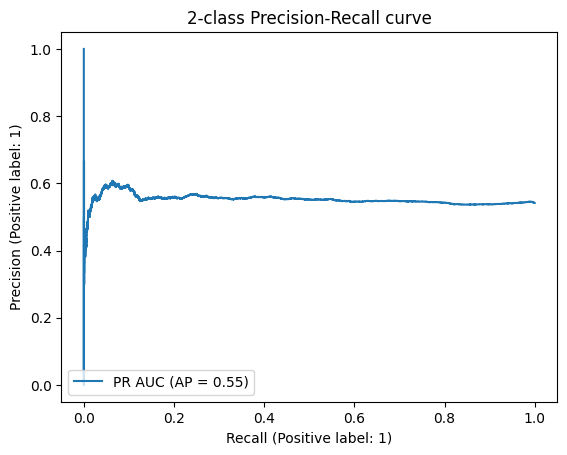

In [28]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.61

### Find the best threshold

ic| bound: 0.3
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.31
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.32
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.33
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.34
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.35
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.36
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.37
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.38
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.39
    prec_score: 0.54167
    obj_num: 7152
    obj_pct: 1.0
    obj_profit: 596
ic| bound: 0.4
    prec_score: 0.54167
    obj_num:

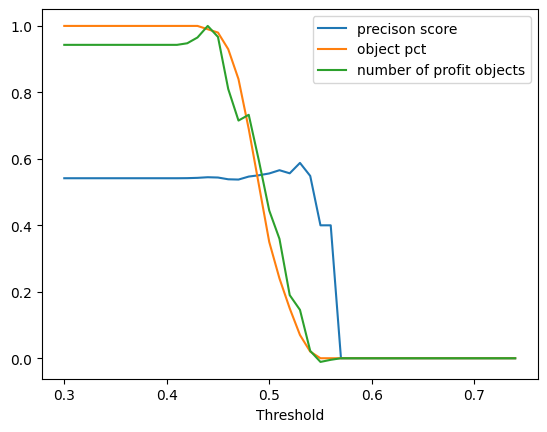

In [29]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round(obj_num * prec_score - obj_num * (1 - prec_score))
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [30]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])